In [1]:
set.seed(888)
# libraries used by different members for the report
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(janitor)
library(lubridate)
library(GGally)
library(ISLR)

# libraries for visualization
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction: 

**The research project**
The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC, led by Professor Frank Wood, is trying to build embodied AI agents that can behave like real human players inside Minecraft. Data was taken from players in a minecraft server called PLAICraft, and the players’ behaviours and traits were recorded. Currently, there are 196 observations of players, and in order to save resources, such as software licenses and server hardware, they need to recruit players who will play on the server for several hours.

**The question**
We want to know if player's characteristics, like their experience, subscription to the game's newsletter, gender, and age can predict how long in hours a player would play according to the dataset players?

**Why**
To better grasp human players behaviors to build a believable AI, significant amounts of data is needed. This data is collected through interactions the players will have in the server. So it is crucial for the recruted participants to stay online for longer amounts of time.

3 characteristics of the players were chosen to be able to provide a comprehensive list of what should be prioritised when recruiting efforts. Since all 3 are all self identified, they may provide bias (social desirability in reporting gender, or overstatement of experience, etc).

The demographic of age was not chosen because as seen in the exploration of the data below, most players have similar ages. The high concentration around a single age group doesnt allow for age to have significance when recruiting. The highest and the lowest contibuting player will both most likely be in the same age range. Age is also a risky variable for prediction since the targeted players could grow older over the time of the research.

Only data set players is needed for this question as it has all the information about the demographic. Sessions could be useful to then see players habits but just to answer the question of most data collected, player habits would be too specific.


**The dataset: players**


There are 196 observations over rows for 7 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| experience | character | 5 | skillset of the player: Beginner, Amateur, Regular, Veteran, Pro|
| subscribe | logical | 2 | indicating active subscription status: TRUE (subscribed) or FALSE (not subscribed) |
| hashedEmail | character | 196 | unique identifications |
| played_hours | real number | n/a | time in hours spent on the server by a player |
| name | character | 196 | unique identifications |
| gender | character | 7 | gender of the player : Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other|
| age | real number | n/a | age of the player |


potential issues:
- gender variable is inclusive but could reduce data accuracy since categories like "Prefer not to say" introduce ambiguity, as they could represent individuals from another gender group
- positively skewed played_hours, majority of values are very close to 0h with a few big outliers (around 200h)
- 3 (experience, gender, age) of the variables are self identified, they may provide bias (social desirability in reporting age or gender, or overstatement of experience, etc).
  - emails and name are self identified as well but are not determining characteristics of players that affect play-time/engagenent. they identify too specifically and dont represent a "type" of player

<h1> Methods and Results </h1>

In order to answer the question--can the following characteristics of a player: experience, subscription to the game's newsletter, gender, predict the player's total played hours-- k-NN Regression model will be used. K-NN Regression is a model used to predict a numerical outcome from a set of predictor variables. Since our label, played hours, is numerical, we would expect to have numerical values for our prediction outcome. First, the players data set is loaded below.


In [2]:
players <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci100-group-008/refs/heads/main/players.csv", show_col_types = FALSE)
head(players)


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Generally, the players data set is already tidy with each row having a single observation, each column a single variable and each value being in a single cell. The character data type is not suitable for the model, therefore we convert it to a factor data type below.

In [3]:
players_tidy <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")),
        gender = as_factor(gender) )
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Shown below is a count of the gender of the players. For simplicity's sake, the genders besides Male and Female will be combined into the Others category. It can also be observed that Agender, Non-binary, Other, Prefer not to say, and Two-Spirited inputs for gender have quite low counts. Therefore, it would be better to combine them into just one category.

In [18]:

players_gender <- players |> count(gender)
players_gender

# Combining the genders with small data into one category
players_tidy <- players_tidy |> mutate(
    gender = case_when(
      gender %in% c("Male") ~ "Male",
      gender %in% c("Female") ~ "Female",
      TRUE ~ "Other"),
    gender = as.factor(gender))


gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


Next, we will be selecting the variables we are going to use. The variables that will be used to predict a player's played hours are experience, subscribe, and gender. As mentioned in the introduction section, we will be excluding age due to most players having a high concentration around a single age group.

The summary statistics for played_hours are shown below.

In [19]:
#Selecting the predictor variables we will be using
players_selected <- select(players_tidy, experience, subscribe, gender, played_hours)


In [20]:
players_relevent_summary <- players |>
  summarise(
    variable = "played_hours",
    mean = mean(played_hours, na.rm = TRUE),
    median = median(played_hours, na.rm = TRUE),
    standard_deviation = sd(played_hours, na.rm = TRUE),
    minimum = min(played_hours, na.rm = TRUE),
    maximum = max(played_hours, na.rm = TRUE))

players_relevent_summary

variable,mean,median,standard_deviation,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,5.845918,0.1,28.35734,0,223.1


The predictor variables chosen (experience, subscribe, and gender) is plotted against played hours in the plots below. Observing the experience graph, players who are at beginner level seem to have low total played hours. While for amateur-level players 

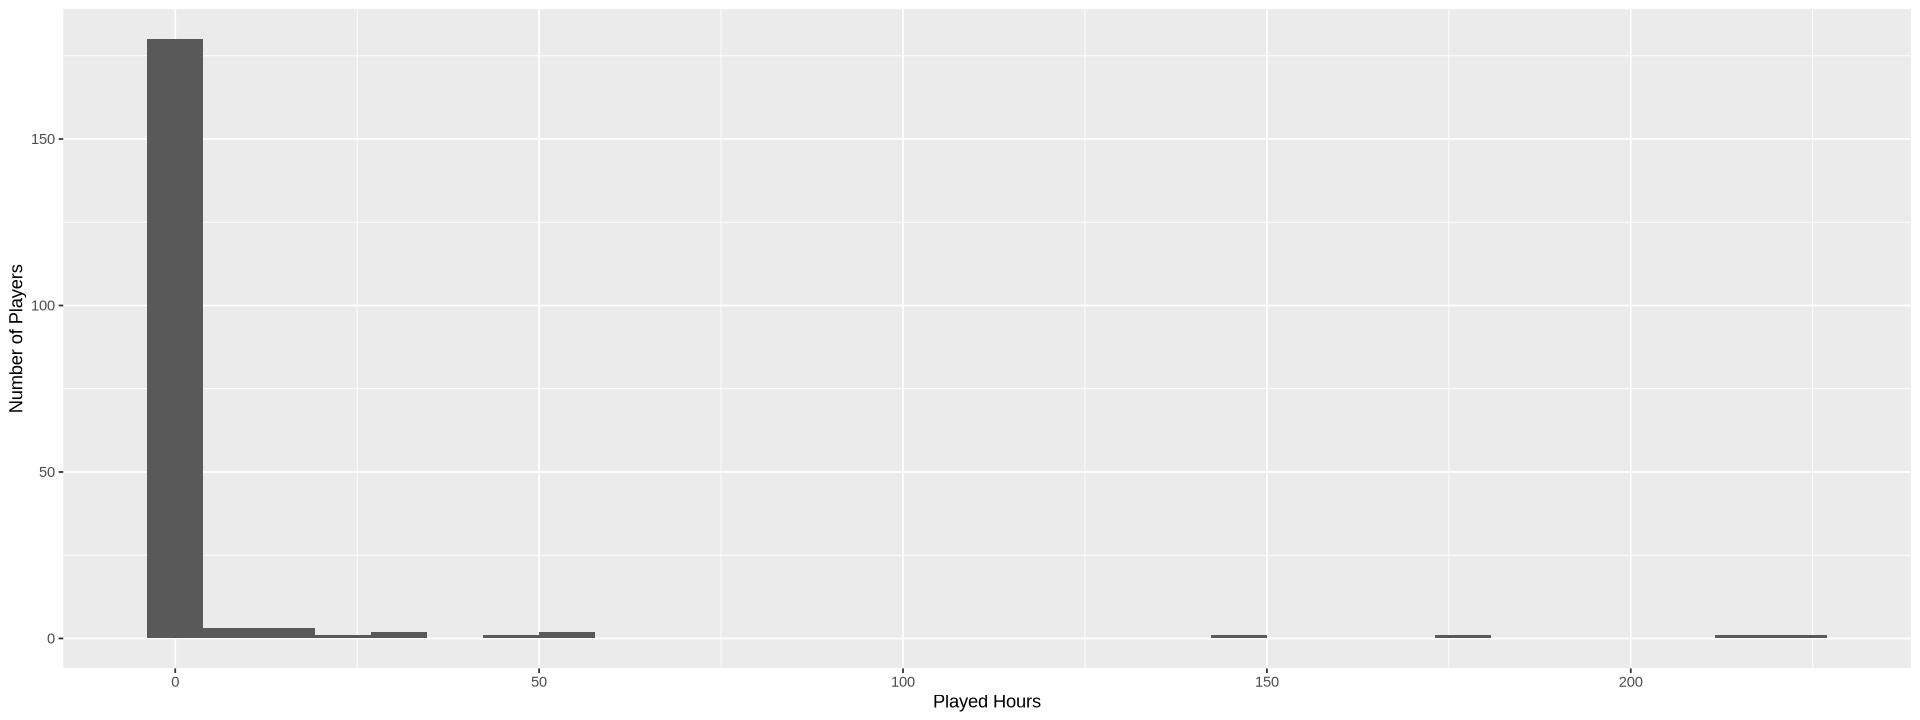

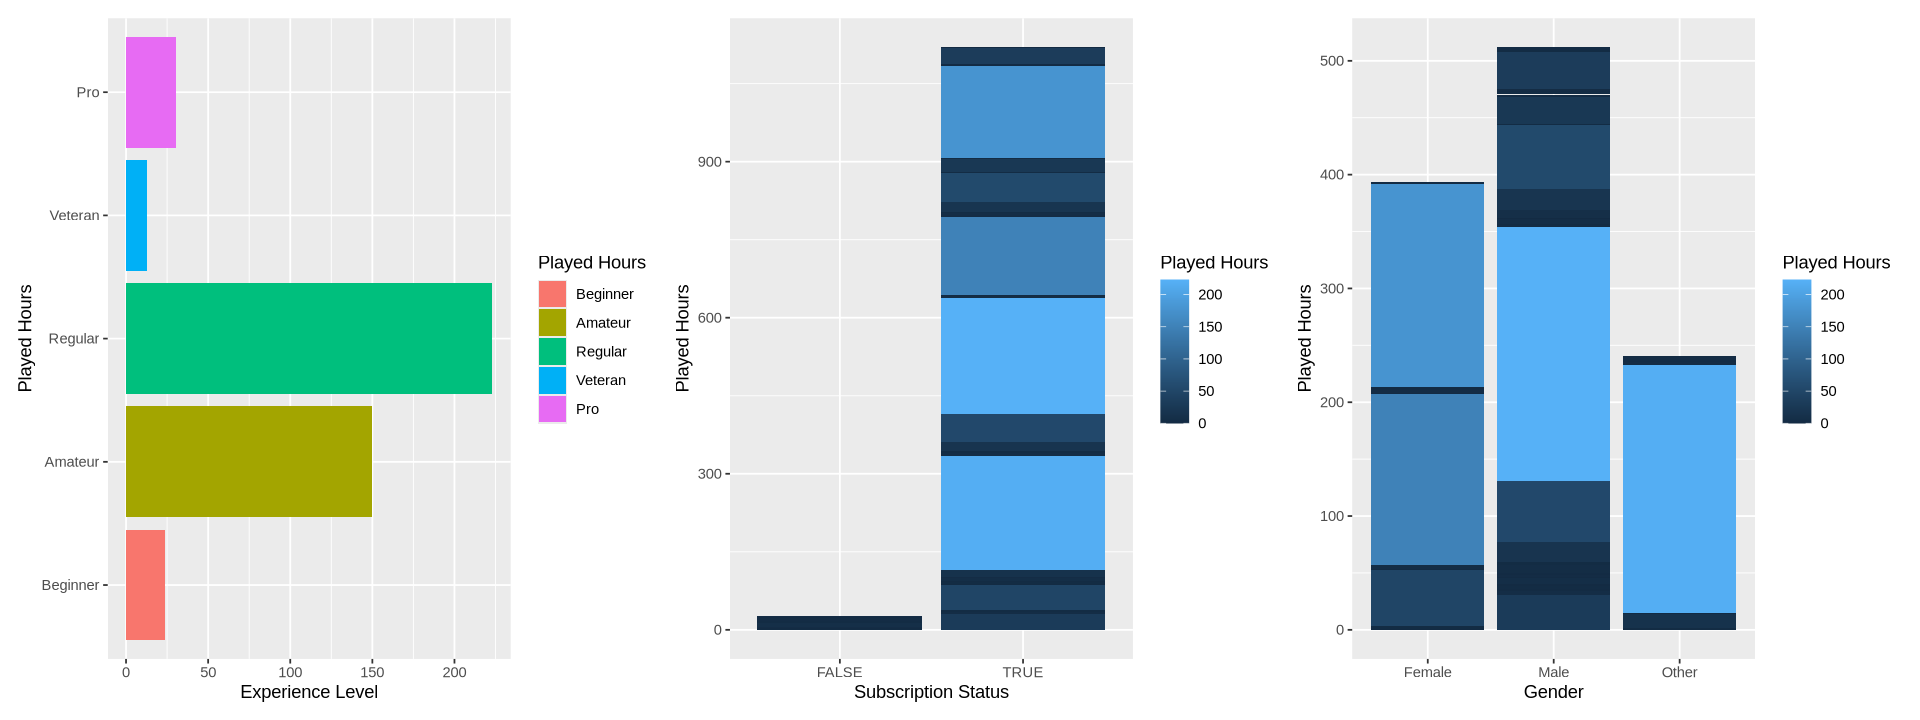

In [32]:

options(repr.plot.width = 16, repr.plot.height = 6)

played_hours_distribution <- players_selected |> ggplot(aes(x= played_hours)) +
geom_histogram(bins=30) +
labs(x= "Played Hours", y= "Number of Players")
played_hours_distribution

experience_played_hours <- players_selected |> ggplot( aes(x= played_hours, y= experience, fill = experience) ) +
geom_bar(stat="identity", position = "dodge") +
xlab("Experience Level") +
ylab("Played Hours")+
labs(fill = "Played Hours")


subscribe_played_hours <- players_selected |> ggplot( aes(x= subscribe, y= played_hours, fill = played_hours) ) +
geom_bar(stat="identity")+
xlab("Subscription Status")+
ylab("Played Hours")+
labs(fill = "Played Hours")


gender_played_hours <- players_selected |> ggplot( aes(x= gender, y= played_hours, fill = played_hours) ) +
geom_bar(stat="identity")+
xlab("Gender")+
ylab("Played Hours")+
labs(fill = "Played Hours")

experience_played_hours + subscribe_played_hours + gender_played_hours 


In the code below, the model is tuned to find out the optimal K to use. After performing the tuning, we find that the optimal k-value to use is 45, because it produces the lowest RMSE.



In [35]:
set.seed(888)

players_split <- initial_split(players_selected, prop = 0.80, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(played_hours~ experience + subscribe + gender, data = players_train) 

players_spec1 <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune() ) |>
set_engine("kknn") |>
set_mode("regression")

players_vfold <- vfold_cv(players_train, v= 5, strata = played_hours)

players_wkflw <- workflow() |>
add_recipe(players_recipe) |>
add_model(players_spec1)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1) )

players_results <- players_wkflw |> 
tune_grid(resamples = players_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse")

players_min <- players_results |>
filter(mean == min(mean) )
players_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
45,rmse,standard,25.56265,5,8.766652,Preprocessor1_Model045


Now that we know our optimal k-value, we can evaluate on the test set to assess how well our model might do on predicting new and unseen data.

In [47]:
players_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 45) |>
set_engine("kknn")|>
set_mode("regression")

players_fit <- workflow() |>
add_recipe(players_recipe) |>
add_model(players_spec2) |>
fit(data = players_train)

players_predictions <- players_fit |>
predict(players_test) |>
bind_cols(players_test) 

players_metrics <- players_predictions|>
metrics(truth = played_hours, estimate = .pred) 

players_predictions
players_metrics





.pred,experience,subscribe,gender,played_hours
<dbl>,<fct>,<lgl>,<fct>,<dbl>
18.7777778,Regular,TRUE,Female,0.0
9.2666667,Beginner,TRUE,Female,1.5
1.7444444,Amateur,TRUE,Male,0.2
5.3377778,Regular,TRUE,Male,0.3
0.6511111,Beginner,TRUE,Male,0.0
5.2777778,Veteran,TRUE,Other,0.1
1.7444444,Amateur,TRUE,Male,0.3
5.2777778,Veteran,TRUE,Other,0.0
5.2777778,Veteran,TRUE,Other,12.5


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.070952784
rsq,standard,0.005474689
mae,standard,5.781111111


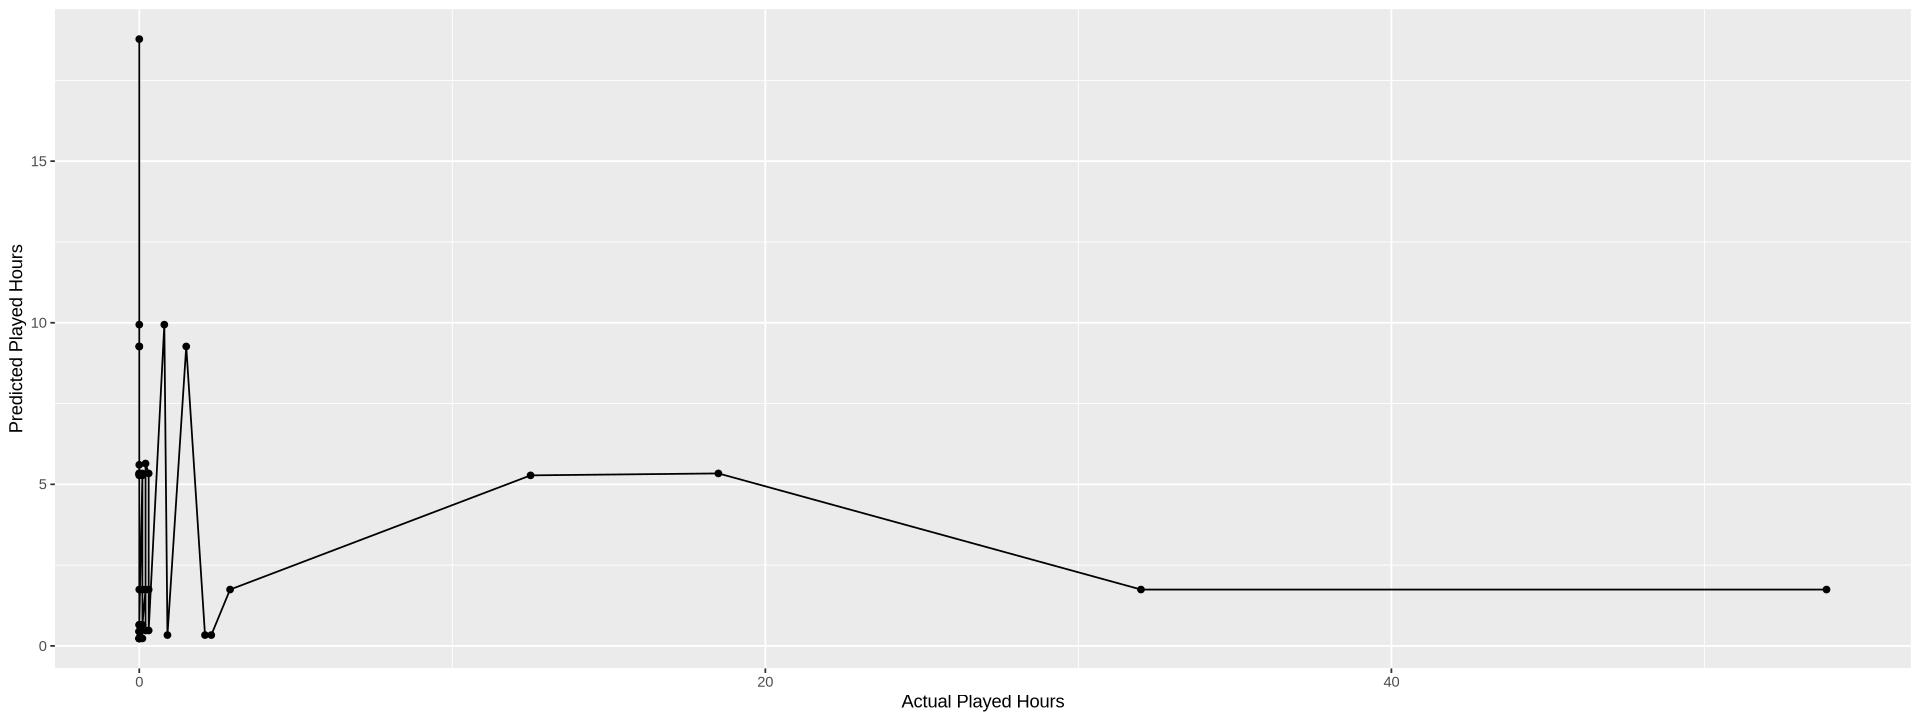

In [48]:
players_plot <- ggplot(players_predictions, aes(x= played_hours, y= .pred) ) +
geom_point()+
geom_line()+
xlab("Actual Played Hours")+
ylab("Predicted Played Hours")
players_plot

The K-NN Regression model shows very low predictive ability. 